# Data Anaysis Project part1:


I am currently enrolled in a Google Data Analytics Professional Certificate course and plan to apply the skills and knowledge I am learning to my own data analysis project. This will allow me to solidify my understanding of the concepts and techniques taught in the course. 

#### Process to follow:
* Ask
* Prepare
* Process
* Analyze
* Share
* Act



## Overview of the project:

I am conducting an analysis of the rental housing market in Vancouver to identify popular rental properties in the area. Based on the results, I hope to find a valuable investment property and assess its value. I have chosen to focus on the Vancouver market because it is the one of the most wanted place in Canada, it offers a wide variety of properties, and large pool of potential investments to analyze. 


# ASK 

## Primery question to answer from this analysis:

### "What is the appropriate price to pay for your investment property in current economic condition? And why?"
    
    It's widely believed that Canadian real estate is overpriced, but what is the actual value of a property? To answer this question, I will evaluate property values based on current market conditions and determin the apporopriate price to pay for an investment property. This calculation involves several factors, but I will focus particularly on the revenue generation potential of the property, as this is a crucial aspect of any investment. By analyzing the revenue potential of a property, I aim to gain insight into its true value. 

#### Data source:

    Craigslist advertizement. Data started to collect since December 15, 2022. 

#### Questions to ask.
* Rental price by propety types.
* Rental price by area. 
* Number of advatizing by type of the property.
* Rental price trend.
* Correlation between housing price and rental price. And which way they are trending. 
* What is the short termand long term prediction.  


## Prepare  

### Collect the Data



In [1]:
# Import libralis
from requests import get
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.figsize": (10, 6), "figure.dpi": 120})
import seaborn as sns

from time import sleep
import re
from random import randint
from warnings import warn
from time import time
from IPython.display import clear_output

In [2]:
class Url:
    def __init__(self, city_name, sub_city=None, num_post=0):
        self.city_name = city_name
        self.sub_city = sub_city
        self.num_post = num_post
        self.url = self.get_url()
        
    def get_url(self):
        if self.city_name == 'Abbotsford':
            url = f'https://{self.city_name.lower()}.craigslist.org/search/apa?s={self.num_post}sort=date&bundleDuplicates=1&min_price=&max_price=&availabilityMode=0&sale_date=all+dates'
        else:
            url = f'https://{self.city_name.lower()}.craigslist.org/search/{self.sub_city}/apa?s={self.num_post}sort=date&bundleDuplicates=1&min_price=&max_price=&availabilityMode=0&sale_date=all+dates'
        return url 

In [3]:
# Vanvouver rental housing
url = Url("Vancouver", 'van')
url_ = url.url

response = get(url_)


soup = BeautifulSoup(response.text, 'html.parser')

posts = soup.find_all('li', class_='result-row')
print(type(posts)) # to double check that I got resultSet
print(len(posts)) # to double check I got 120 elements

<class 'bs4.element.ResultSet'>
124


In [4]:
%%time
# Find the total number of posts to find the limit of the pagination
city = 'Vancouver'
sub_city = 'van'
response = get(url_)
soup = BeautifulSoup(response.text, 'html.parser')
posts = soup.find_all('li', class_='result-row')
results_num = soup.find('div', class_='search-legend')
results_total = int(results_num.find('span', class_='totalcount').text)
print(f"Total number of search result: {results_total}")

# each page has 119 posts so each new page is defined as follows; s=120, s=240, .....
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_date = []
post_cities = []
num_bedroom = []
sqfts = []
prices = []
post_titles = []
post_links = []

for page in pages:
    
    # get request
    url = Url(city_name=city, sub_city=sub_city, num_post=page)
    url_ = url.url
    response = get(url_)
    
    sleep(1)
    
    # throw warning for status code that are not 200
    if response.status_code != 200:
        warn(f'Request: {requests}; Status code: {response.status_code}')
        
    soup = BeautifulSoup(response.text, 'html.parser')
    
    posts = soup.find_all('li', class_='result-row')
    
    
    # Extract data 
    for post in posts:
        
        if post.find('span', class_ = 'result-hood') is not None:
            
            # Posting date
            post_datetime = post.find('time', class_='result-date')['datetime']
            post_date.append(post_datetime)
            
            # Neighbourhoods
            post_city = post.find('span', class_='result-hood').text.strip('( )')
            post_cities.append(post_city)
            
            # title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_titles.append(post_title_text)
            
            # Post price in integer
            price = int(post.find('span', class_='result-price').text.split('$')[1].replace(',', ''))
            prices.append(price)
            
            # Post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    num_bedroom.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    num_bedroom.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    num_bedroom.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    num_bedroom.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                num_bedroom.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    num_bedroom.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
        iterations += 1
        #print("Page" + str(iterations) + "Scraped Successfully!")   

Total number of search result: 3000
CPU times: total: 4.27 s
Wall time: 48.4 s


In [78]:
# create DataFrame
df = pd.DataFrame({'Post Datetime': post_date,
                   'City Code': city.upper()[:3],
                   'Area Code': sub_city.upper(),
                   'Post Title': post_titles,
                   'Post URL': post_links,
                  'Neighborhood': post_cities,
                  'Bedroom': num_bedroom,
                  'SQFT': sqfts,
                  'Price': prices})

print(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3072 entries, 0 to 3071
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Post Datetime  3072 non-null   object 
 1   City Code      3072 non-null   object 
 2   Area Code      3072 non-null   object 
 3   Post Title     3072 non-null   object 
 4   Post URL       3072 non-null   object 
 5   Neighborhood   3072 non-null   object 
 6   Bedroom        2825 non-null   object 
 7   SQFT           2769 non-null   float64
 8   Price          3072 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 216.1+ KB
None


,Post Datetime,City Code,Area Code,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price
0,2023-01-11 09:33,VAN,VAN,One bedroom Garden Suite for Rent,https://vancouver.craigslist.org/van/apa/d/van...,Langara / Oakridge,1,806.0,1955
1,2023-01-11 09:31,VAN,VAN,3 Bed 3.5 Bath Luxury Penthouse w/ 360 Degree ...,https://vancouver.craigslist.org/van/apa/d/van...,Downtown Vancouver,3,2050.0,11995
2,2023-01-11 09:30,VAN,VAN,1 Bed + Den 1 Bath Condo in Crosstown w/ City ...,https://vancouver.craigslist.org/van/apa/d/van...,Downtown Vancouver,1,680.0,2995
3,2023-01-11 09:30,VAN,VAN,Well-Maintained 2 Bed + Den 2 Bath Condo with...,https://vancouver.craigslist.org/van/apa/d/van...,Coal Harbour,2,802.0,4250
4,2023-01-11 09:30,VAN,VAN,Unfurnished 3 Bedroom Townhouse w/ 5 Balconies...,https://vancouver.craigslist.org/van/apa/d/van...,Downtown Vancouver,3,1700.0,6495



## Process

* Clean data
    * Remove duplecates.
    * If the number of bed room is NaN, assume it is bachelor suite (number of bedroom as 0)
    * Convert Post Datetime object to Datetime, then seperate Date and Time. 
    * Sort the dataFrame by Post Datetime. 
    * Convert number of bedroom string to integer. 
    * Detect outliers, then do something with them.
* Add parameters to analyze data
    * Specific neighbourhood and clean up messy neighbourhoode. 
    * Post area code connecting the city name and area name to distinguish different area in future with other data. 
    * Calcualte Price/SQFT
    * Find out if the suite is furnished or not by finding the key word "Furnished" in the post title. 
    * Seperate the data by SQFT/Price price range. gategory 1 to 4, which 1 is cheap and 4 is expensive. 
    * I also use unsupervised learning to categorize the dataset. 

In [79]:
# Convert Datetime then split seperate columns
df['Post Datetime'] = pd.to_datetime(df["Post Datetime"])
df['Post Date'] = df['Post Datetime'].dt.date
df['Post Time'] = df['Post Datetime'].dt.time

df["PostAreaCode"] = df["City Code"] + df["Area Code"]

lower_neighbor = []
for area in df["Neighborhood"]:
    neighbor = area.lower()
    lower_neighbor.append(neighbor)
df["Neighborhood"] = lower_neighbor

df = df[["PostAreaCode", 'Post Datetime', 'Post Date', 'Post Time', 'Post Title', 'Post URL', 'Neighborhood', 'Bedroom', 'SQFT', 'Price']]
df.head()

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price
0,VANVAN,2023-01-11 09:33:00,2023-01-11,09:33:00,One bedroom Garden Suite for Rent,https://vancouver.craigslist.org/van/apa/d/van...,langara / oakridge,1,806.0,1955
1,VANVAN,2023-01-11 09:31:00,2023-01-11,09:31:00,3 Bed 3.5 Bath Luxury Penthouse w/ 360 Degree ...,https://vancouver.craigslist.org/van/apa/d/van...,downtown vancouver,3,2050.0,11995
2,VANVAN,2023-01-11 09:30:00,2023-01-11,09:30:00,1 Bed + Den 1 Bath Condo in Crosstown w/ City ...,https://vancouver.craigslist.org/van/apa/d/van...,downtown vancouver,1,680.0,2995
3,VANVAN,2023-01-11 09:30:00,2023-01-11,09:30:00,Well-Maintained 2 Bed + Den 2 Bath Condo with...,https://vancouver.craigslist.org/van/apa/d/van...,coal harbour,2,802.0,4250
4,VANVAN,2023-01-11 09:30:00,2023-01-11,09:30:00,Unfurnished 3 Bedroom Townhouse w/ 5 Balconies...,https://vancouver.craigslist.org/van/apa/d/van...,downtown vancouver,3,1700.0,6495


In [80]:
# Convert Bedroom number strings to Integer then NaN value to 0 assume 0 bedroom is studio appartment. 
df["Bedroom"] = pd.to_numeric(df["Bedroom"], errors='ignore').astype('Int64')
df["Bedroom"] = df["Bedroom"].fillna(0)

In [81]:
%%time
# Check if word 'furnished' in the title post. 
search_word = 'furnished'
furnished = []
for i in range(len(df)):
    post_title_list = df['Post Title'][i].lower().split(" ")
    if any(word == search_word for word in post_title_list):
        furnished.append(True)
    else:
        furnished.append(False)
df["IsFurnished"] = furnished

CPU times: total: 0 ns
Wall time: 13 ms


Get the per SQFT price. Then categorize the dataframe by price.

In [82]:
# Calculate Price/SQFT
df["Price/SQFT"] = df["Price"] / df["SQFT"]
df['Price/SQFT'].fillna(0, inplace=True)
df["SQFT"] = df["SQFT"].fillna(0)
p_per_sqft_df = df[["Neighborhood", "Bedroom", "Price", "Price/SQFT"]].sort_values(by="Price/SQFT", ascending=False)

In [83]:
df['Price/SQFT'].describe()

count    3072.000000
mean        4.679227
std        41.280360
min         0.000000
25%         3.000000
50%         4.013217
75%         4.995833
max      2250.000000
Name: Price/SQFT, dtype: float64

In [84]:
# Categorize the data by price range
df['price_range'] = pd.cut(df['Price/SQFT'], bins=[-1, 0.5, 3.4, 4.2, 5.8, max(df['Price/SQFT'])+1], labels=[0, 1, 2, 3, 4], include_lowest=False)

In [85]:
# Sort DataFrame by Datetime
df.sort_values(by="Post Datetime", axis=0, ascending=False, inplace=True)

In [86]:
# Remove duplicates by post title
df.drop_duplicates(subset="Post Title", inplace=True)
df = df.reset_index(drop=True)
len(df)

2642

## check the ouliers in lower prices:

I noticed that there are some $0 and $1 ads. I assume those are just to not show the price. Also, I see some very low price ads like less than $300. I will find out what kind of ads are thoses. 

In [87]:
# Price less than $300
df[df['Price'] < 300]

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
61,VANVAN,2023-01-11 08:15:00,2023-01-11,08:15:00,Westsea Place - (Westend) - Studio & 1 Bedroom...,https://vancouver.craigslist.org/van/apa/d/del...,1644 nelson st.,0,0.0,0,False,0.000000,0
483,VANVAN,2023-01-10 08:12:00,2023-01-10,08:12:00,scam! beware 1 bdrm in freesia building downto...,https://vancouver.craigslist.org/van/apa/d/van...,downtown vancouver,1,755.0,1,False,0.001325,0
1294,VANVAN,2023-01-07 05:35:00,2023-01-07,05:35:00,"House for rent Maple Ridge, BC, 3br - 2569ft...",https://vancouver.craigslist.org/van/apa/d/map...,23013 olund crescent,0,0.0,0,False,0.000000,0
2179,VANVAN,2022-12-27 11:48:00,2022-12-27,11:48:00,Quay Pacific,https://vancouver.craigslist.org/van/apa/d/abb...,vancouver and lower mainland,3,0.0,0,False,0.000000,0
2527,VANVAN,2022-12-17 15:59:00,2022-12-17,15:59:00,Need help with housing,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,0,0.0,1,False,0.000000,0


This post with the Price less than 300 dollar is daily rental. From this, I assume teh rental price around 100 dollar would be daily rental suite. 

What about 1 dollar or 0 dollar posts?

In [88]:
# $1 ads
one_dollar = df[df["Price"] == 1]
one_dollar["Post URL"]

483     https://vancouver.craigslist.org/van/apa/d/van...
2527    https://vancouver.craigslist.org/van/apa/d/van...
Name: Post URL, dtype: object

In [89]:
# $0 ads
zero_dollar = df[df["Price"] == 0]
zero_dollar

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
61,VANVAN,2023-01-11 08:15:00,2023-01-11,08:15:00,Westsea Place - (Westend) - Studio & 1 Bedroom...,https://vancouver.craigslist.org/van/apa/d/del...,1644 nelson st.,0,0.0,0,False,0.0,0
1294,VANVAN,2023-01-07 05:35:00,2023-01-07,05:35:00,"House for rent Maple Ridge, BC, 3br - 2569ft...",https://vancouver.craigslist.org/van/apa/d/map...,23013 olund crescent,0,0.0,0,False,0.0,0
2179,VANVAN,2022-12-27 11:48:00,2022-12-27,11:48:00,Quay Pacific,https://vancouver.craigslist.org/van/apa/d/abb...,vancouver and lower mainland,3,0.0,0,False,0.0,0


In [91]:
# Drop low-end outliers rows
drop_index = []
for idx in one_dollar.index:
    drop_index.append(idx)
for idx in zero_dollar.index:
    drop_index.append(idx)
print(f"Original DataFrame Size:{len(df)}\nNumber of Dropped Rows: {len(drop_index)}")
df.drop(drop_index,axis=0, inplace=True)
print(f"DataFrame size after drop rows: {len(df)}")

Original DataFrame Size:2642
Number of Dropped Rows: 5
DataFrame size after drop rows: 2637


### Drop High-end outliers

In [93]:
# Show the highest price of the ads to see what kind of properties charges such a high price.  
df.sort_values(by='Price', ascending=False).head()

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
158,VANVAN,2023-01-10 20:48:00,2023-01-10,20:48:00,Point Grey Road Home with Expansive Views,https://vancouver.craigslist.org/van/apa/d/van...,west side - kitsilano,3,2445.0,35000,False,14.314928,4
1438,VANVAN,2023-01-06 09:39:00,2023-01-06,09:39:00,Furnished Two Bedroom Sub-Penthouse at Shangri...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,2694.0,25000,True,9.279881,4
234,VANVAN,2023-01-10 16:37:00,2023-01-10,16:37:00,Furnished luxury Mansion 7 bed/7 bath availabl...,https://vancouver.craigslist.org/van/apa/d/wes...,west vancouver,6,10000.0,22880,True,2.288000,1
1894,VANVAN,2023-01-02 20:41:00,2023-01-02,20:41:00,*FURNISHED OPTION AVAILABLE* RARE HARBOUR GRE...,https://vancouver.craigslist.org/van/apa/d/van...,"coal harbour front row, vancouver",4,4000.0,21800,False,5.450000,3
673,VANVAN,2023-01-09 16:00:00,2023-01-09,16:00:00,Coal Harbour Luxury 3 Bedroom Apartment,https://vancouver.craigslist.org/van/apa/d/van...,vancoover,3,3636.0,20000,False,5.500550,3


In [25]:
#If I find the outlier for high price, I will drop the row. 
df.drop(df[df["Price"] == 500000].index, axis=0, inplace=True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2642 entries, 0 to 2641
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   PostAreaCode   2642 non-null   object        
 1   Post Datetime  2642 non-null   datetime64[ns]
 2   Post Date      2642 non-null   object        
 3   Post Time      2642 non-null   object        
 4   Post Title     2642 non-null   object        
 5   Post URL       2642 non-null   object        
 6   Neighborhood   2642 non-null   object        
 7   Bedroom        2642 non-null   Int64         
 8   SQFT           2642 non-null   float64       
 9   Price          2642 non-null   int64         
 10  IsFurnished    2642 non-null   bool          
 11  Price/SQFT     2642 non-null   float64       
 12  price_range    2642 non-null   category      
dtypes: Int64(1), bool(1), category(1), datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 235.1+ KB


## Analyze the data to understanding the Data

Use visualization to understand the data. 



In [94]:
# First to see correlation matrix
df.corr()

,Bedroom,SQFT,Price,IsFurnished,Price/SQFT
Bedroom,1.000000,0.356818,0.553635,-0.050830,-0.003987
SQFT,0.356818,1.000000,0.361562,0.008760,-0.014986
Price,0.553635,0.361562,1.000000,0.102103,-0.001471
IsFurnished,-0.050830,0.008760,0.102103,1.000000,-0.003962
Price/SQFT,-0.003987,-0.014986,-0.001471,-0.003962,1.000000


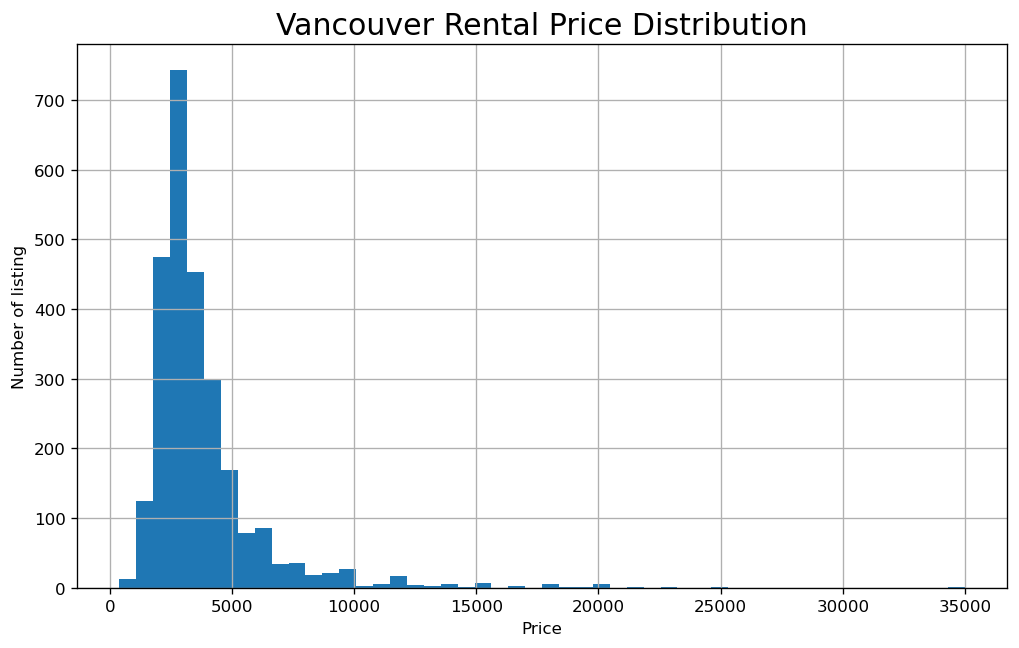

In [95]:
df['Price'].hist(bins=50)
plt.title('Vancouver Rental Price Distribution', fontsize=18)
plt.xlabel("Price")
plt.ylabel('Number of listing');

## Relationship between Price and SQFT

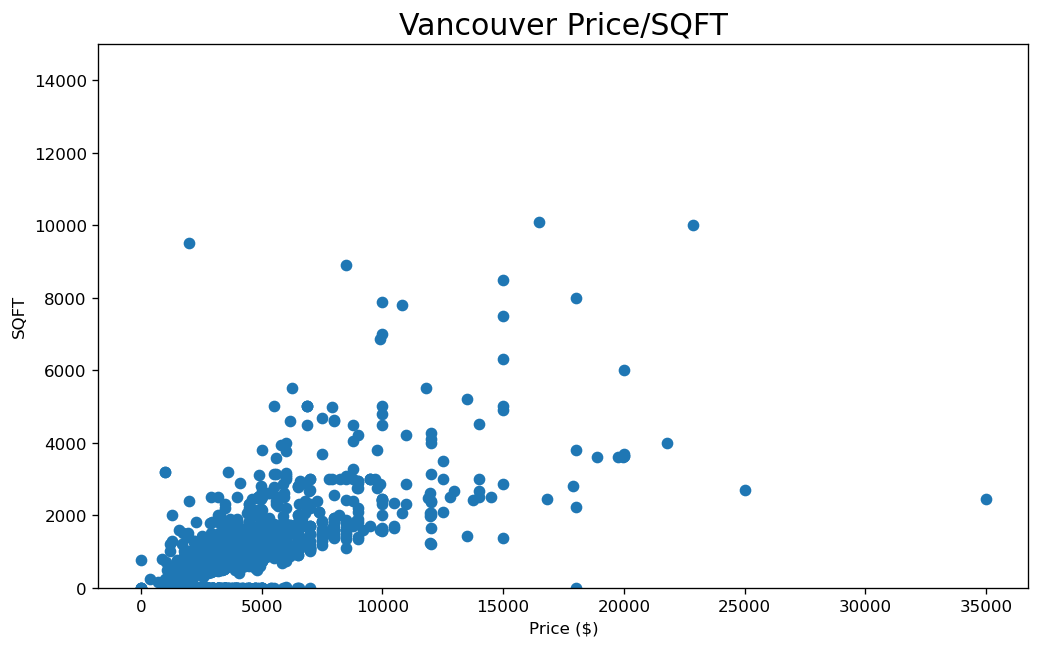

In [33]:
# Relationship between SQFT and Price
plt.scatter(x=df["Price"], y=df["SQFT"])
plt.ylim((0, 15000))
plt.title(f"{city} Price/SQFT", fontsize=18)
plt.xlabel(f"Price ($)")
plt.ylabel(f"SQFT")
plt.show()

## Relationship between Price and number of Bedrooms

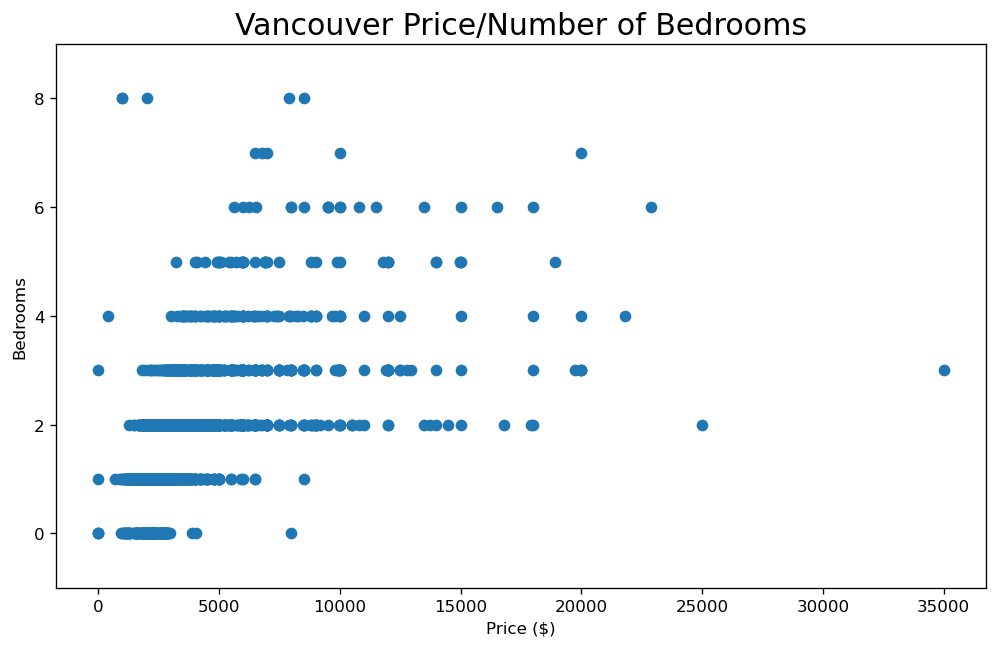

In [37]:
plt.scatter(x=df["Price"], y=df["Bedroom"])
plt.ylim((-1, 9))
plt.title(f"{city} Price/Number of Bedrooms", fontsize=18)
plt.xlabel(f"Price ($)")
plt.ylabel(f"Bedrooms")
plt.show()

## Distribution of Per SQFT Price

In [96]:
df.sort_values(by='Price/SQFT', ascending=False).head()

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
67,VANVAN,2023-01-11 08:03:00,2023-01-11,08:03:00,east van/commercial drive,https://vancouver.craigslist.org/van/apa/d/van...,grandview/woodland,2,1.0,2250,False,2250.000000,4
2582,VANVAN,2022-12-15 14:47:00,2022-12-15,14:47:00,Yaletown brand new 3 bedroom high end apartment,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,3,14.0,6000,False,428.571429,4
158,VANVAN,2023-01-10 20:48:00,2023-01-10,20:48:00,Point Grey Road Home with Expansive Views,https://vancouver.craigslist.org/van/apa/d/van...,west side - kitsilano,3,2445.0,35000,False,14.314928,4
1869,VANVAN,2023-01-03 10:05:00,2023-01-03,10:05:00,PW Whitehouse-PENTHOUSE 1002 - 3BR + 2BA + Roo...,https://vancouver.craigslist.org/van/apa/d/van...,downtown vancouver,3,1379.0,15000,False,10.877447,4
2186,VANVAN,2022-12-27 10:08:00,2022-12-27,10:08:00,"Fully Furnished, Serviced One Bedroom Apartmen...",https://vancouver.craigslist.org/van/apa/d/van...,downtown,1,475.0,4800,False,10.105263,4


In [97]:
# Drop outliers
df_priceSqft_outlier =df[df['Price/SQFT'] > 15]
df_priceSqft_outlier

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
67,VANVAN,2023-01-11 08:03:00,2023-01-11,08:03:00,east van/commercial drive,https://vancouver.craigslist.org/van/apa/d/van...,grandview/woodland,2,1.0,2250,False,2250.000000,4
2582,VANVAN,2022-12-15 14:47:00,2022-12-15,14:47:00,Yaletown brand new 3 bedroom high end apartment,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,3,14.0,6000,False,428.571429,4


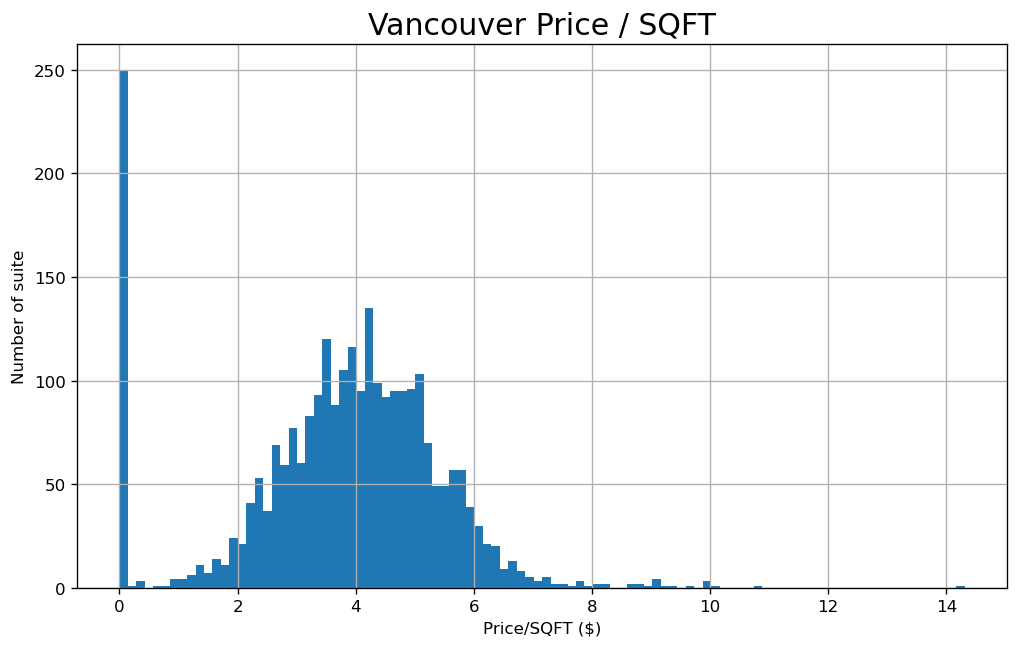

In [98]:
df_priceSQFT = df.drop(df_priceSqft_outlier.index, axis=0)
df_priceSQFT["Price/SQFT"].hist(bins=100)
plt.title(f"{city} Price / SQFT", fontsize=18)
plt.xlabel("Price/SQFT ($)")
plt.ylabel("Number of suite")
#plt.xlim((-1, 20))
plt.show()

I noticed that the lots of the data is $0. I will take those data to see the price distribution. 

In [99]:
df_zero = df[df['Price/SQFT'] == 0]

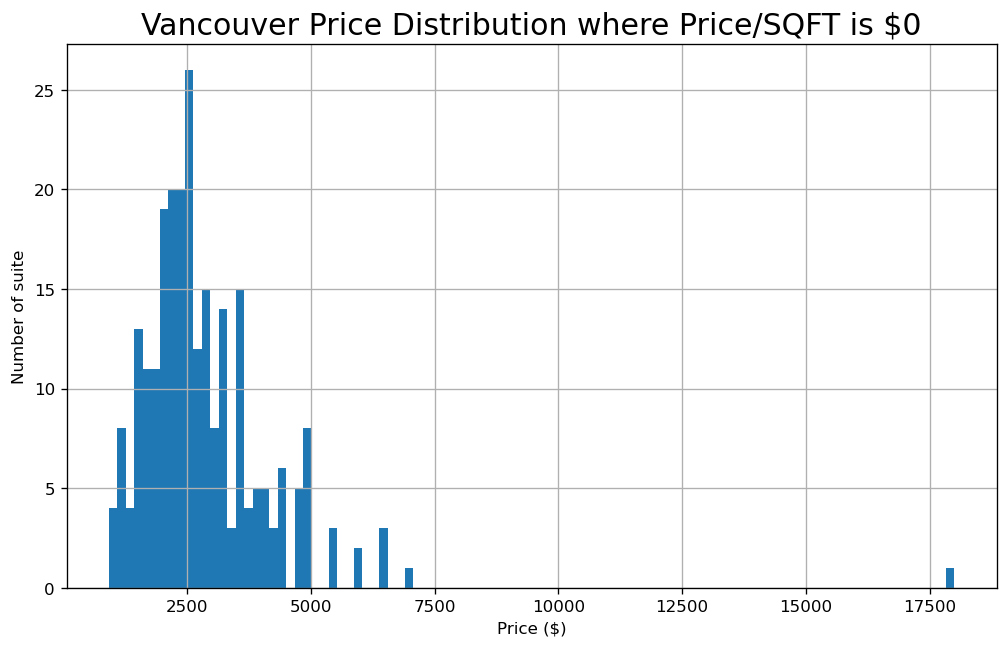

In [100]:
df_zero["Price"].hist(bins=100)
plt.title(f"{city} Price Distribution where Price/SQFT is $0", fontsize=18)
plt.xlabel("Price ($)")
plt.ylabel("Number of suite")
#plt.xlim((-1, 20))
plt.show()

This distribution shows that the price on the SQFT of 0 is normary distributed. I think I can use this as one sample for just a Price. 

## Number of ads on each bedroom

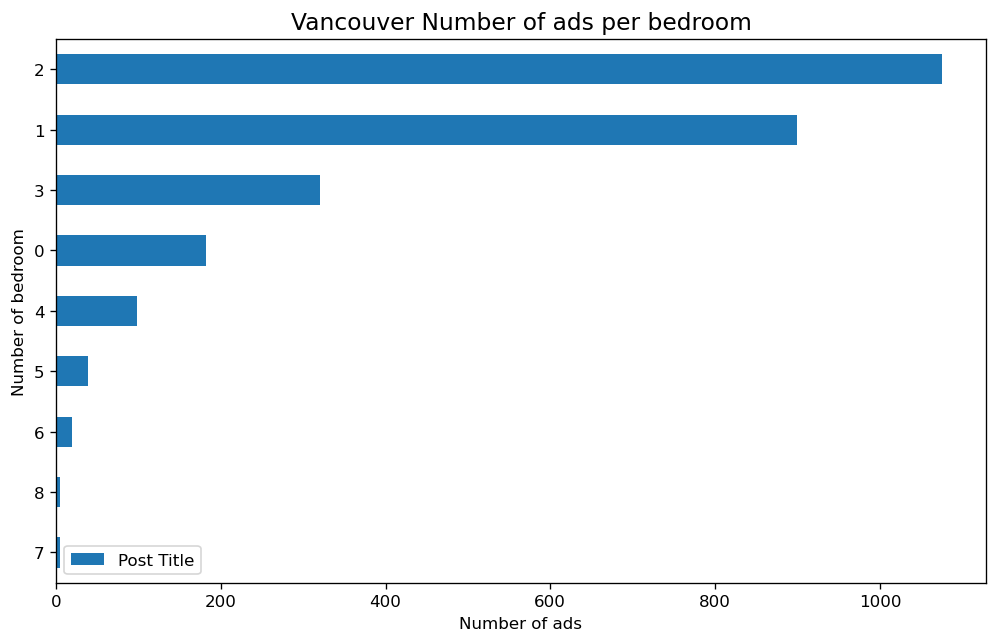

In [66]:
num_bed = df.groupby('Bedroom').agg({'Post Title': 'count'}).sort_values(by='Post Title', ascending=True)
num_bed.plot(kind='barh')
plt.title(f"{city} Number of ads per bedroom", fontsize=14)
plt.xlabel("Number of ads")
plt.ylabel("Number of bedroom");

In [67]:
# Percentage of the number of listing. 
num_bed["percent"] = num_bed / len(df) * 100
num_bed.rename(columns={'Post Title': "Number of Ads", 'percent': 'Percentage'}, inplace=True)

In [70]:
num_bed.sort_values(by='Percentage', ascending=False)

,Number of Ads,Percentage
Bedroom,,
2,1075,40.688872
1,899,34.027252
3,320,12.112036
0,182,6.888721
4,98,3.709311
5,39,1.476154
6,19,0.719152
7,5,0.189251
8,5,0.189251


As you see the data, the most ads are 1 bedroom and 2 bedrooms suite. 

## Check the data by categories:

Earlier, I split the data by Price/SQFT range. I do this to find some pattern in each price range to predict the rental price so Ican evaluat the Property values. 

0
count    254.000000
mean       0.004971
std        0.038962
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.386049
Name: Price/SQFT, dtype: float64

1
count    647.000000
mean       2.664932
std        0.555267
min        0.640000
25%        2.333333
50%        2.769231
75%        3.125000
max        3.400000
Name: Price/SQFT, dtype: float64

2
count    598.000000
mean       3.803824
std        0.237752
min        3.401361
25%        3.579004
50%        3.804780
75%        4.000000
max        4.200000
Name: Price/SQFT, dtype: float64

3
count    930.000000
mean       4.891593
std        0.445898
min        4.200323
25%        4.519950
50%        4.852928
75%        5.210425
max        5.800000
Name: Price/SQFT, dtype: float64

4
count    206.000000
mean       6.638551
std        1.133502
min        5.808758
25%        5.953647
50%        6.221404
75%        6.735325
max       14.314928
Name: Price/SQFT, dtype: float64



2635

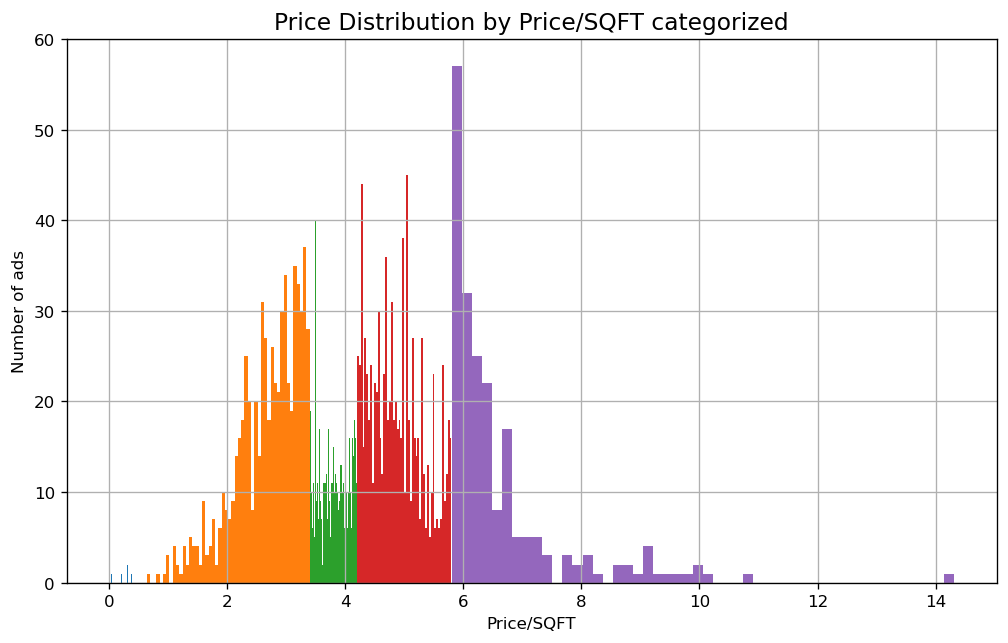

In [101]:
df_grouped = df_priceSQFT.groupby('price_range')

number_row = 0
# Print data frame, lenth of data by category
for name, group in df_grouped:
    print(name)
    group['Price/SQFT'].hist(bins=50)
    plt.ylim(0, 60)
    plt.title("Price Distribution by Price/SQFT categorized", fontsize=14)
    plt.xlabel('Price/SQFT')
    plt.ylabel('Number of ads')
    print(group["Price/SQFT"].describe())
    number_row += len(group)
    print()
number_row

# Conclusion (Share findings):

### Answer to the primery question:

#### What is the appropriate price to pay for your investment property in current economic condition? And why?

Is is very hard to answer this question from this data. The price range is so wide. I think the price is based on the area, and I can't specify the area from this data. 

At the end of this research, I split the data by the Price/SQFT price range. I will do farther analysis with those data if I can find some pattern from each data to specify the rental price to evaluate the property price. 

Also, I will keep collecting the data from same source, then later I will look for the rental price trend to predict where the rental price will go towards. I am already seeing the house price drops from interest rate hike. If the rental price will increase or not change, then investors have more chance to find the profitable properties. 

## Analyze - 1

From the Histgram, the highest amount of rental is between 1000 to 5000. First I look what kind of market above 5000. 

I call this as 

## High-End market research


In [34]:
# top 100 higest price 
top_100_price = df[['Post Datetime', 'Neighborhood', 'Bedroom', 'SQFT', 'Price', 'IsFurnished']].sort_values(
                by="Price", ascending=False).head(100)
top_100_price.head(30)


,Post Datetime,Neighborhood,Bedroom,SQFT,Price,IsFurnished
1000,2023-01-05 21:10:00,west end,3,2445.0,35000,False
942,2023-01-06 09:39:00,vancouver,2,2694.0,25000,True
98,2023-01-08 15:17:00,west vancouver,6,10000.0,22880,True
2197,2022-12-25 10:18:00,vancouver,3,3636.0,20000,False
1401,2023-01-04 10:43:00,dowtown,4,3700.0,19998,False
205,2023-01-08 10:06:00,west vancouver,7,6000.0,19995,True
692,2023-01-06 18:39:00,west vancouver,3,3600.0,19975,False
1402,2023-01-04 10:43:00,west vancouver,3,3600.0,19750,False
1688,2023-01-02 20:41:00,west vancouver,5,3600.0,18900,True
2222,2022-12-24 01:41:00,west vancouver,6,8000.0,18000,False


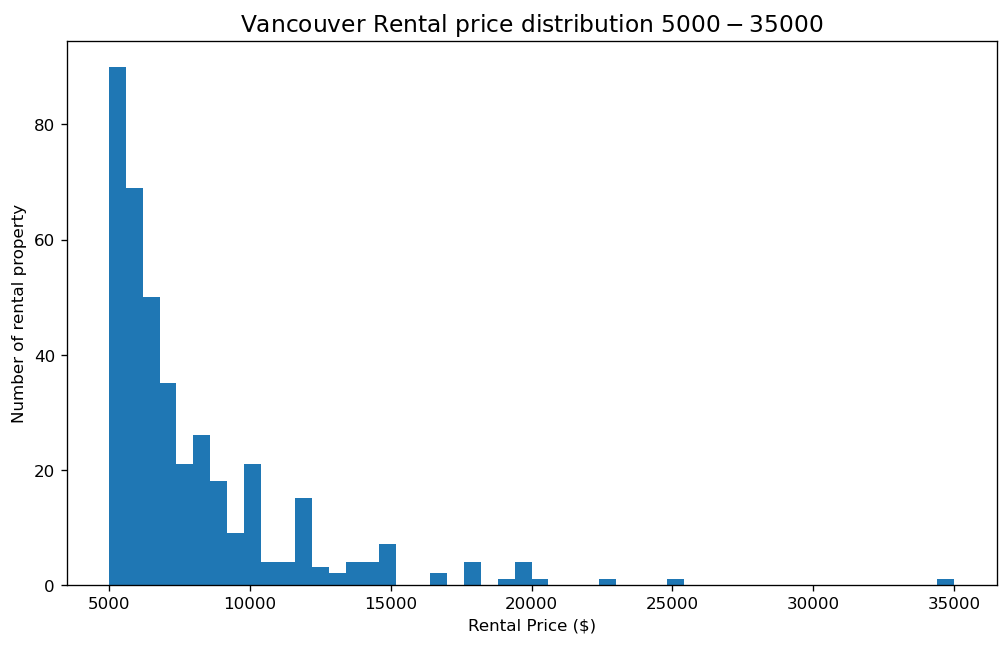

In [35]:
# What about distribution $5000 and up?
price_range = (5000, df["Price"].max())
plt.hist(df["Price"], bins=50, range=price_range)
plt.title(f'{city} Rental price distribution ${price_range[0]} - ${price_range[1]}', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

In [36]:
# Get URL on 2 Bedroom suite in top 100. 
highest_two_bed = top_100_price[top_100_price['Bedroom'] == 2]
highest_two_bed_idx = highest_two_bed.index
for idx in highest_two_bed_idx:
    print(f'Index Number - {idx} : {df.loc[idx]["Post URL"]}')


Index Number - 942 : https://vancouver.craigslist.org/van/apa/d/vancouver-furnished-two-bedroom-sub/7568419814.html
Index Number - 1834 : https://vancouver.craigslist.org/van/apa/d/rare-harbour-green-one-ft-stunning/7563703745.html
Index Number - 419 : https://vancouver.craigslist.org/van/apa/d/vancouver-fairmont-loft-bedroom/7571765246.html
Index Number - 485 : https://vancouver.craigslist.org/van/apa/d/vancouver-uniqueaccommodationscom/7567894912.html
Index Number - 1348 : https://vancouver.craigslist.org/van/apa/d/vancouver-breathtaking-views-2500-sq-ft/7574957274.html
Index Number - 1404 : https://vancouver.craigslist.org/van/apa/d/vancouver-super-luxury-07-fairmont-bed/7574861790.html
Index Number - 1115 : https://vancouver.craigslist.org/van/apa/d/vancouver-luxurious-private-estates-of/7575279054.html
Index Number - 2270 : https://vancouver.craigslist.org/van/apa/d/vancouver-br-den-for-lease-across/7571047691.html
Index Number - 418 : https://vancouver.craigslist.org/van/apa/d/va

#### What is 0.85% RULE?

This is the rough calculation to find out the purchase price to give 5 - 8% cash flow from your rental revenue with today's motgagerate. It's not accurate number but great place to start evaluating the home price for your investment. 

In [37]:
# Average Price on those pent house
avg_rent = np.average(highest_two_bed["Price"][1:].to_numpy())
max_rent = np.max(highest_two_bed["Price"][1:].to_numpy())
# 0.85% RULE
avg_house_p = np.round(avg_rent / (0.85/100), 2)
max_house_p = np.round(max_rent / (0.85/100), 2)
print(f"Price between ${avg_house_p*0.8} - ${max_house_p}")

Price between $1058352.944 - $2105882.35


In [38]:
# Rental price higher than $5000.
more_than_5000 = df[df["Price"] > 5000]
more_than_5000.groupby(by=["Bedroom", "IsFurnished"]).agg({'SQFT': ["min", "max"],
                                                         "Price": ['min', 'max', 'count']})

SQFT          Price             
                        min      max   min    max count
Bedroom IsFurnished                                    
0       True         1357.0   1357.0  8000   8000     1
1       False         900.0   2000.0  6495   6500     2
        True          733.0   1855.0  5500   8500     4
2       False           0.0   2936.0  5190  17900    88
        True            0.0   2873.0  5100  25000    60
3       False           0.0   3636.0  5100  35000    72
        True         1000.0   4000.0  5200  12950    34
4       False           0.0   6300.0  5200  19998    39
        True         1400.0   4200.0  5500  12500    16
5       False           0.0   6850.0  5200  14995    19
        True         2500.0   4913.0  6000  18900     9
6       False        2300.0  10098.0  5600  18000    12
        True         2300.0  29789.0  6550  22880     7
7       False           0.0   3000.0  6500   7000     3
        True         4800.0   6000.0  9995  19995     2
8       False        3073.0   4980.0  7900   8500     2

In [39]:
# top 10 most expensive rental in Vancouver
top_10 = top_100_price.head(10)
top_10

,Post Datetime,Neighborhood,Bedroom,SQFT,Price,IsFurnished
1000,2023-01-05 21:10:00,west end,3,2445.0,35000,False
942,2023-01-06 09:39:00,vancouver,2,2694.0,25000,True
98,2023-01-08 15:17:00,west vancouver,6,10000.0,22880,True
2197,2022-12-25 10:18:00,vancouver,3,3636.0,20000,False
1401,2023-01-04 10:43:00,dowtown,4,3700.0,19998,False
205,2023-01-08 10:06:00,west vancouver,7,6000.0,19995,True
692,2023-01-06 18:39:00,west vancouver,3,3600.0,19975,False
1402,2023-01-04 10:43:00,west vancouver,3,3600.0,19750,False
1688,2023-01-02 20:41:00,west vancouver,5,3600.0,18900,True
2222,2022-12-24 01:41:00,west vancouver,6,8000.0,18000,False


In [40]:
# Then get the URL on those top 10 most expensive rental in Vancouver. 
top_10_idx = top_10.index
for idx in top_10_idx:
    print(f'Index Number - {idx}/Number of Bedroom - {df.loc[idx]["Bedroom"]}/SQFT - {df.loc[idx]["SQFT"]}/Location - {df.loc[idx]["Neighborhood"]}\n{df.loc[idx]["Post URL"]}')

Index Number - 1000/Number of Bedroom - 3/SQFT - 2445.0/Location - west end
https://vancouver.craigslist.org/van/apa/d/vancouver-point-grey-road-home-with/7574690925.html
Index Number - 942/Number of Bedroom - 2/SQFT - 2694.0/Location - vancouver 
https://vancouver.craigslist.org/van/apa/d/vancouver-furnished-two-bedroom-sub/7568419814.html
Index Number - 98/Number of Bedroom - 6/SQFT - 10000.0/Location - west vancouver
https://vancouver.craigslist.org/van/apa/d/west-vancouver-furnished-luxury-mansion/7574307946.html
Index Number - 2197/Number of Bedroom - 3/SQFT - 3636.0/Location - vancouver 
https://vancouver.craigslist.org/van/apa/d/vancouver-coal-harbour-luxury-three/7563551392.html
Index Number - 1401/Number of Bedroom - 4/SQFT - 3700.0/Location - dowtown 
https://vancouver.craigslist.org/van/apa/d/vancouver-one-of-kind-4br-luxury/7574865851.html
Index Number - 205/Number of Bedroom - 7/SQFT - 6000.0/Location - west vancouver
https://vancouver.craigslist.org/van/apa/d/west-vancouv

From above data, Downtown Vanvouver rental market is different world. I must make decision to define what is the outlier of high-end rental. 

If the number of the high-end prices are large enough, I can make DataFrame for only high-end and search for the high-end market opportunities. 

Clearly, I should not mix with regular market and high-end market because it will provide me biased price average to determin the valuse of the house. 

I am wondering that <a href='https://www03.cmhc-schl.gc.ca/hmip-pimh/en/TableMapChart/Table?TableId=2.1.31.3&GeographyId=2410&GeographyTypeId=3&DisplayAs=Table&GeograghyName=Vancouver'>CMHC Vancouver rental market report</a> concerns about those outliers. 

## Analyze - 2 


## Analyze under 5000, and i call them for regular market. 
* What is the percentage of the Furnished rental suite? 
* Is there any price different? 
* How many bedroom suite has most on ads? And is it any different in area?
* How much is the rental price in general? 


Tne price around $100 is most likely daily rental so I will store in different variable so I might be able to do something with them. 

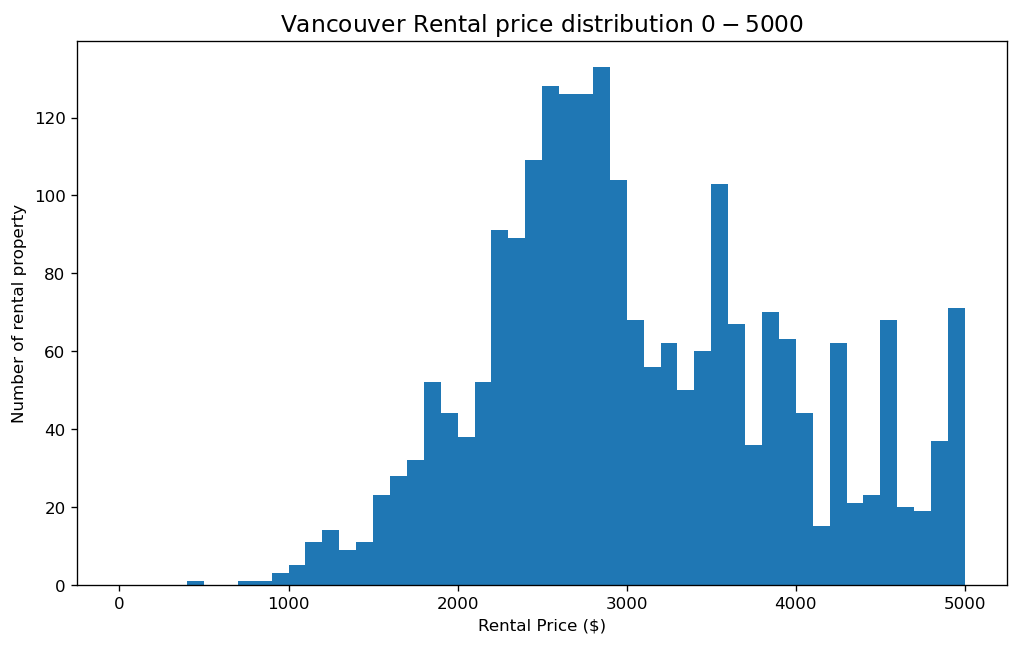

In [41]:
# What about distribution $0 - $5000?
price_range = (0, 5000)
plt.hist(df["Price"], bins=50, range=price_range)
plt.title(f'{city} Rental price distribution ${price_range[0]} - ${price_range[1]}', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

In [42]:
day_rental = df[df["Price"].between(10, 300)]
day_rental

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range


In [43]:
# Drop the rental price over $5000. 
under_5000 = df.drop(more_than_5000.index, axis=0)
print(f'Drop {len(more_than_5000)} rows and data contains {len(under_5000)} rows of data.')

Drop 370 rows and data contains 2246 rows of data.


In [44]:
# then also drop daily rentals
under_5000 = under_5000.drop(day_rental.index, axis=0)
print(f'Drop {len(day_rental)} rows and data contains {len(under_5000)} rows of data.')

Drop 0 rows and data contains 2246 rows of data.


In [45]:
# What is the top 10 highest price on under $5000. Is it no outlier?
under_5000.sort_values(by="Price", ascending=False).head(10)

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
0,VANVAN,2023-01-08 20:09:00,2023-01-08,20:09:00,House for rent!,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,4,1470.0,5000,False,3.401361,2
566,VANVAN,2023-01-07 09:16:00,2023-01-07,09:16:00,Pet Friendly 2 Bed 1 Bath Beach Themed Condo,https://vancouver.craigslist.org/van/apa/d/van...,kitsilano,2,900.0,5000,False,5.555556,3
808,VANVAN,2023-01-06 14:44:00,2023-01-06,14:44:00,1335 Howe-luxury 2 beds 2 baths with view,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,1200.0,5000,False,4.166667,2
1564,VANVAN,2023-01-03 15:55:00,2023-01-03,15:55:00,3 Bedroom House with In-law suite Available f...,https://vancouver.craigslist.org/van/apa/d/sur...,surrey,3,2150.0,5000,False,2.325581,1
1531,VANVAN,2023-01-03 18:14:00,2023-01-03,18:14:00,House for rent - furnished or not,https://vancouver.craigslist.org/van/apa/d/nor...,vancouver,4,0.0,5000,True,0.000000,0
1810,VANVAN,2023-01-01 11:14:00,2023-01-01,11:14:00,"Beautiful Suite at Kits Point - 2 Floors, 2 Bd...",https://vancouver.craigslist.org/van/apa/d/van...,kitsilano,2,1500.0,5000,True,3.333333,1
875,VANVAN,2023-01-06 11:37:00,2023-01-06,11:37:00,Arthur Erickson Waterfall Building 1 Bed + Den...,https://vancouver.craigslist.org/van/apa/d/van...,armory district,1,1000.0,5000,False,5.000000,3
1498,VANVAN,2023-01-03 22:46:00,2023-01-03,22:46:00,2bed plus den rent (high end condo),https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,975.0,5000,False,5.128205,3
1169,VANVAN,2023-01-05 09:41:00,2023-01-05,09:41:00,3 Bedroom 2 Bathroom Townhouse,https://vancouver.craigslist.org/van/apa/d/van...,kitsilano,3,1600.0,5000,False,3.125000,1
1447,VANVAN,2023-01-04 07:18:00,2023-01-04,07:18:00,NEW BUILDING-Available March 1st -Pet Friendly...,https://vancouver.craigslist.org/van/apa/d/van...,downtown,3,745.0,5000,False,6.711409,4


In [46]:
# How many rentals are $5000?
under_5000[under_5000["Price"] == 5000] 

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
0,VANVAN,2023-01-08 20:09:00,2023-01-08,20:09:00,House for rent!,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,4,1470.0,5000,False,3.401361,2
130,VANVAN,2023-01-08 13:49:00,2023-01-08,13:49:00,Fully furnished 2 bed & 2 bathroom,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,0.0,5000,True,0.000000,0
159,VANVAN,2023-01-08 12:00:00,2023-01-08,12:00:00,1 BLOCK TO BEACH!!! Kitsilano - Character - L...,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,2,0.0,5000,False,0.000000,0
474,VANVAN,2023-01-07 12:10:00,2023-01-07,12:10:00,(UniqueAccommodations.com) ID:5184 Kitsilano 2...,https://vancouver.craigslist.org/van/apa/d/van...,kitsilano,2,1100.0,5000,False,4.545455,3
566,VANVAN,2023-01-07 09:16:00,2023-01-07,09:16:00,Pet Friendly 2 Bed 1 Bath Beach Themed Condo,https://vancouver.craigslist.org/van/apa/d/van...,kitsilano,2,900.0,5000,False,5.555556,3
718,VANVAN,2023-01-06 18:11:00,2023-01-06,18:11:00,A/C Furnished Short term Apartment at Avenue O...,https://vancouver.craigslist.org/van/apa/d/van...,olympic village,2,1000.0,5000,True,5.000000,3
792,VANVAN,2023-01-06 15:32:00,2023-01-06,15:32:00,Downtown-Telus Garden! 37F-FUNISHED LUXURY 2 B...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,1050.0,5000,False,4.761905,3
808,VANVAN,2023-01-06 14:44:00,2023-01-06,14:44:00,1335 Howe-luxury 2 beds 2 baths with view,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,1200.0,5000,False,4.166667,2
875,VANVAN,2023-01-06 11:37:00,2023-01-06,11:37:00,Arthur Erickson Waterfall Building 1 Bed + Den...,https://vancouver.craigslist.org/van/apa/d/van...,armory district,1,1000.0,5000,False,5.000000,3
998,VANVAN,2023-01-05 21:12:00,2023-01-05,21:12:00,"Eco Penthouse Loft, with Private Roof Deck",https://vancouver.craigslist.org/van/apa/d/van...,west end,2,900.0,5000,False,5.555556,3


In [47]:
# What is the cheapest rent?
under_5000.sort_values(by="Price").head(20)

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT,price_range
1261,VANVAN,2023-01-04 20:40:00,2023-01-04,20:40:00,2 rooms for rent - Vancouver,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,4,250.0,400,False,1.600000,1
1627,VANVAN,2023-01-03 11:38:00,2023-01-03,11:38:00,Microsuite Available Now,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,150.0,700,False,4.666667,3
72,VANVAN,2023-01-08 16:23:00,2023-01-08,16:23:00,Basement Unit,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,0,198.0,800,False,4.040404,2
2474,VANVAN,2022-12-16 11:50:00,2022-12-16,11:50:00,student accommodation,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,800.0,900,False,1.125000,1
1940,VANVAN,2022-12-29 11:28:00,2022-12-29,11:28:00,Micro-Mini suite(Ground Level 5th and Nanaimo/...,https://vancouver.craigslist.org/van/apa/d/mic...,vancouver east,0,191.0,950,False,4.973822,3
790,VANVAN,2023-01-06 15:36:00,2023-01-06,15:36:00,Bachelor Suite Available February,https://vancouver.craigslist.org/van/apa/d/van...,vancouver - chinatown,1,0.0,980,False,0.000000,0
1794,VANVAN,2023-01-01 14:37:00,2023-01-01,14:37:00,#201 Micro Unit - BCCL Heritage Building,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,0,239.0,1000,False,4.184100,2
287,VANVAN,2023-01-08 05:58:00,2023-01-08,05:58:00,Vancouver Westside New Reno house for rent,https://vancouver.craigslist.org/van/apa/d/van...,west vancouver,8,3200.0,1000,False,0.312500,0
1558,VANVAN,2023-01-03 16:24:00,2023-01-03,16:24:00,Bachelor & 1 Bedroom Apartments in Seniors bui...,https://vancouver.craigslist.org/van/apa/d/van...,downtown,1,0.0,1015,False,0.000000,0
128,VANVAN,2023-01-08 13:59:00,2023-01-08,13:59:00,Gastown Micro Units,https://vancouver.craigslist.org/van/apa/d/van...,gastown,0,0.0,1025,False,0.000000,0


In [48]:
# Count how many rentals are furnished 
num_furnished_suite = df[df['IsFurnished'] == True]["IsFurnished"].count()
num_unfurnished_suite = len(df) - num_furnished_suite
furnished_suite_percent = np.round((num_furnished_suite / len(df)) * 100, 2)
print(f"Number of furnished suite is {num_furnished_suite}, and it's {furnished_suite_percent}% of the entire list.")

Number of furnished suite is 657, and it's 25.11% of the entire list.


In [49]:
# Find out the number of ads on each bedrooms number.  
num_bed = np.sort(df["Bedroom"].unique())
suite_counts = []
for i in range(len(num_bed)):
    suite_count = len(df[df['Bedroom'] == num_bed[i]])
    suite_counts.append(suite_count)
    #print(f'Number of {num_bed[i]} Bedroom suite: {len(df[df["Bedroom"] == num_bed[i]])}')
#print(f"List of suite counts: {suite_counts}")

In [50]:
# Find out Mean, Max, Min of SQFT and Price of each bedroom and SUM of furnished suite and total suite on each bedroom. 
df_count = df.groupby(by=['Bedroom']).agg({'SQFT': ['mean', 'max', 'min'],
                                                 'Price': ['mean', 'max', 'min'],
                                                  'IsFurnished': ['sum', 'count']})
df_count['percent furnished'] = df_count['IsFurnished']['sum'] / df_count["IsFurnished"]['count']
df_count

SQFT                          Price              IsFurnished  \
                mean      max     min          mean    max   min         sum   
Bedroom                                                                        
0         391.690217   1357.0     0.0   2251.777174   8000   800          61   
1         554.416667   2400.0     0.0   2599.607778   8500   700         250   
2         909.739739   2936.0     0.0   3978.203358  25000  1280         245   
3        1332.012987   4000.0     0.0   5434.113636  35000  1800          64   
4        2241.625000   6300.0     0.0   6541.352273  19998   400          19   
5        3403.513514   6850.0     0.0   8015.378378  18900  3200           9   
6        7131.684211  29789.0  2300.0  11282.368421  22880  5600           7   
7        3340.000000   6000.0     0.0  10058.000000  19995  6500           2   
8        3751.000000   4980.0  3073.0   5800.000000   8500  1000           0   

              percent furnished  
        count                    
Bedroom                          
0         184          0.331522  
1         900          0.277778  
2        1072          0.228545  
3         308          0.207792  
4          88          0.215909  
5          37          0.243243  
6          19          0.368421  
7           5          0.400000  
8           3          0.000000

In [51]:
# Price per furnished suit on each bedroom
#df_price_furnished = df.drop(['Post Datetime', 'Post Title', 'Post URL', 'Neighborhood'], axis=1)
df_price_furnished = df.groupby(['Bedroom', 'IsFurnished']).agg({'Price': ['mean', 'max', 'min', 'count'],
                                                               "SQFT": ['mean', 'max', 'min']})
df_price_furnished

Price                            SQFT           \
                             mean    max   min count         mean      max   
Bedroom IsFurnished                                                          
0       False         2091.398374   4050   800   123   368.073171    817.0   
        True          2575.163934   8000  1590    61   439.311475   1357.0   
1       False         2476.226154   6500   700   650   556.601538   2400.0   
        True          2920.400000   8500  1200   250   548.736000   1855.0   
2       False         3776.350665  17900  1280   827   888.706167   2936.0   
        True          4659.559184  25000  2150   245   980.738776   2873.0   
3       False         5280.786885  35000  2000   244  1305.340164   3636.0   
        True          6018.671875  12950  1800    64  1433.703125   4000.0   
4       False         6235.710145  19998   400    69  2238.666667   6300.0   
        True          7651.315789  12500  3500    19  2252.368421   4200.0   
5       False         7213.714286  14995  3200    28  3385.785714   6850.0   
        True         10509.444444  18900  6000     9  3458.666667   4913.0   
6       False        10953.750000  18000  5600    12  6272.833333  10098.0   
        True         11845.714286  22880  6550     7  8604.000000  29789.0   
7       False         6766.666667   7000  6500     3  1966.666667   3000.0   
        True         14995.000000  19995  9995     2  5400.000000   6000.0   
8       False         5800.000000   8500  1000     3  3751.000000   4980.0   

                             
                        min  
Bedroom IsFurnished          
0       False           0.0  
        True            0.0  
1       False           0.0  
        True            0.0  
2       False           0.0  
        True            0.0  
3       False           0.0  
        True            0.0  
4       False           0.0  
        True            0.0  
5       False           0.0  
        True         2500.0  
6       False        2300.0  
        True         2300.0  
7       False           0.0  
        True         4800.0  
8       False        3073.0

Dropped extrimely low price add, and it seems no outlier on the price

In [52]:
# Count how many ads per day.1=Mon, 2=Tue, ......, 7=Sun
df["Weekday"] = df["Post Datetime"].dt.isocalendar().day
num_ad_per_day_df = df.groupby('Post Date').agg({'Post Title': 'count',
                                                "Weekday": 'first'})

num_ad_per_day_df

,Post Title,Weekday
Post Date,,
2022-12-12,3,1
2022-12-13,59,2
2022-12-14,39,3
2022-12-15,41,4
2022-12-16,33,5
2022-12-17,14,6
2022-12-18,21,7
2022-12-19,48,1
2022-12-20,34,2


Which day of the week have more ads? 

Is there any day of the week that having more ads than others? 

## Share

#### Data Visualization:
The most important thing is what information do I want to tell. 

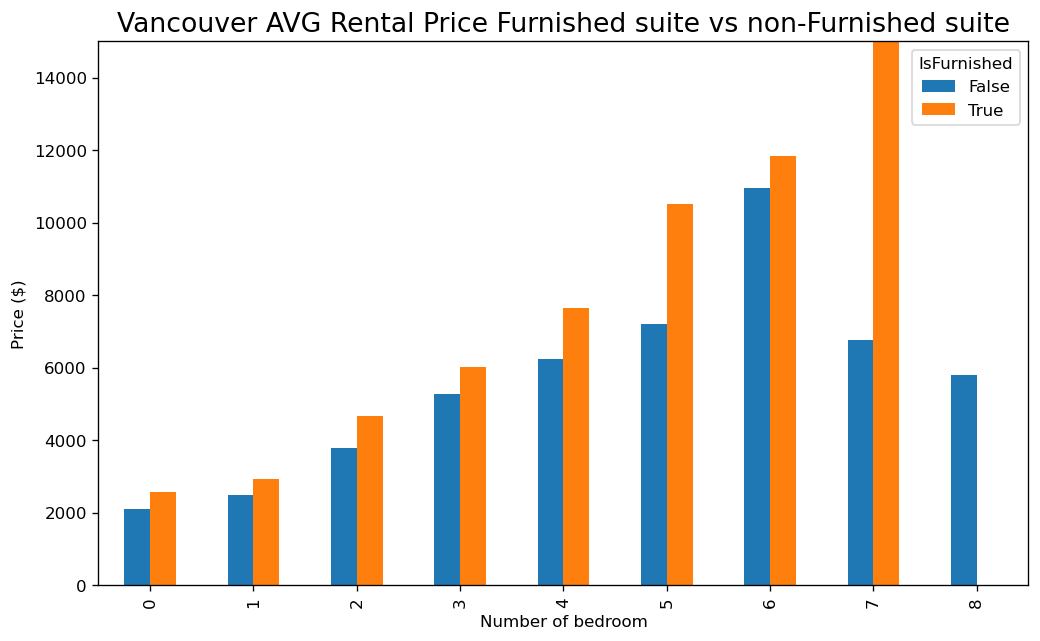

In [53]:
df_price_furnished["Price"]["mean"].unstack().plot(kind='bar')
plt.title(f'{city} AVG Rental Price Furnished suite vs non-Furnished suite', fontsize=16)
plt.xlabel('Number of bedroom')
plt.ylabel('Price ($)')
plt.ylim((0, 15000));

In [54]:
np.mean(df["Price/SQFT"])

3.9497280906362793

## Act